In [236]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
from pylcp.atom import atom
import scipy.constants as cts
from numpy import random as rnd
from pylcp.common import progressBar
import pandas as pd
import magpylib as mg
import numpy.random 
import magpylib as magpy
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import rv_continuous
import concurrent.futures as cf

# Setting up constants

In [237]:
import numpy as np

# Constants
k_B = 1.380649e-23  # Boltzmann constant in J/K
T = 723.15  # Temperature in Kelvin
m = 173 * 1.66054e-27  # Mass of Yb-173 atom in kg

# Mean velocity
mean_velocity = np.sqrt((8 * k_B * T) / (np.pi * m))

# Standard deviation of velocity
std_dev_velocity = np.sqrt(k_B * T / m)

print("Mean Velocity:", mean_velocity, "m/s")
print("Standard Deviation of Velocity:", std_dev_velocity, "m/s")

Mean Velocity: 297.49397280855686 m/s
Standard Deviation of Velocity: 186.4267009435587 m/s


In [238]:
mass_lab = 173*cts.value('atomic mass constant') # YB-173 mass in kg
v_a = mean_velocity
sd_yb = std_dev_velocity


klab = 2*np.pi*25068.2222
# Lab wavevector (without 2pi) in cm^{-1}   # Lifetime of 6P_{3/2} state (in seconds)
gammalab = (1.93*1e8)
Blab = -67*1e-3#(v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')
b_0L =  48*1e-3
# (v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')/2
# T # About 15 G/cm is a typical gradient for Rb
L = 16
x0 = 1/klab  # cm
t0 = 1/gammalab  # s
#100*(mass_lab*(v0**2))/(0.5*cts.hbar*(klab*100)*gammalab) +5
print(Blab, L,b_0L)

-0.067 16 0.048


In [ ]:
# Now, here are our `natural' length and time scales:
x0 = 1/klab  # distance in cm
t0 = 1/gammala # time in s
vc = x0/t0*(1/100) # velcoity in cm/s for conversion back to s.i units
Fc = cts.hbar*klab*100*gammalab # force in newtond for conversion back to s.i units

mass = mass_lab*(x0*1e-2)**2/cts.hbar/t0

# And now our wavevector, decay rate, and magnetic field gradient in these units:
k = klab*x0
gamma = gammalab*t0
alpha = cts.value('Bohr magneton')*Blab*t0/cts.hbar
b_0 = cts.value('Bohr magneton')*b_0L*t0/cts.hbar 
l = L/x0 

print(x0, t0, mass, k, gamma, alpha,b_0)

6.348872362073421e-06 5.181347150259067e-09 2119.188266564296 1.0 1.0 -30.52874111941582 21.871336921372524


# Magnetic field profile

In [239]:
def mag(R,B_0,alpha,l):
    if R[2] > l or R[2] < 0:
       return  np.array([0,0,0])
    else:
        return np.array([B_0 +alpha*(np.sqrt(1-R[2]/l)),0,0])

In [240]:
zeeman_prof = magpy.Collection()
j = 30
n = 8
a = 0# distance it circles aroundthe center 
c = 30 #angle of first bar
d =  24#angle of second bar
b = -190# distnace the two section of the array are apart from each other
k = -100 #the first and second magnent are apart
e = 40
l = -5
p= -20# distance the thrid and 4th magnet are apart from each other
m  = -42
mystyle = mstyle = dict(
    mode="color+arrow",
    color=dict(north="magenta", middle="white", south="turquoise"),
    arrow=dict(width=2, color="k")
)
angles = np.linspace(0, 360, n, endpoint=False)
for i in angles:
    cube1= magpy.magnet.Cuboid(
    dimension=(6,6,125),
    polarization=(-(1.080),0,0),
    position=(70+a+l,0,140+k))
    cube2 = magpy.magnet.Cuboid(dimension= (4,4,25),
    polarization=(-1.17,0,0),
    position=(60+a+l,0,50+e),style_magnetization = mystyle)
    cube3= magpy.magnet.Cuboid(
    dimension=(6,6,125),
    polarization=(1.08,0,0),
    position=(91.5+m,0,320+b))
 
#     cube5 = magpy.magnet.Cuboid(dimension= (4,4,25),
#     polarization=(-1.17,0,0),
#     position=(90+a+p+m,0,190))

#     cube6 = magpy.magnet.Cuboid(dimension= (4,4,25),
#     polarization=(-1.17,0,0),
#     position=(80+a+p+m,0,200),
# )
   


    cube1.rotate_from_angax(i, 'z')
    cube1.rotate_from_angax(c, 'y',)
    cube1.rotate_from_angax(i, 'z', anchor=0)
 
 
    cube2.rotate_from_angax(i, 'z',anchor = 0)
    cube2.rotate_from_angax(i, 'z')
    cube3.rotate_from_angax(i, 'z', anchor=0)
    cube3.rotate_from_angax(-d, 'y')
    cube3.rotate_from_angax(i, 'z')
  
    #cube4.rotate_from_angax(i, 'z', anchor=0)
    #cube4.rotate_from_angax(-d, 'y')
    #cube4.rotate_from_angax(i, 'z')
    

    zeeman_prof.add(cube1)
    zeeman_prof.add(cube2)
    zeeman_prof.add(cube3)
    #zeeman_prof.add(cube4)
    # zeeman_prof.add(cube5)
    # zeeman_prof.add(cube6)
    j = j+1


tfmot = magpy.Collection()
N = 4
angles = np.linspace(0,360,N,endpoint=False)
pol = [0,180,0,180]
l = 35
halbach = magpy.Collection()
mystyle = mstyle = dict(
    mode="color+arrow",
    color=dict(north="magenta", middle="white", south="turquoise"),
    arrow=dict(width=2, color="k"),
)
for a in range(len(angles)):
    cube= magpy.magnet.Cuboid(
    dimension=(8,6,80),
    polarization=(1.17,0,0),
    position=(30+l,0,230),
    style_magnetization = mystyle)
    print(a)
    cube.rotate_from_angax(angles[a], 'z',anchor = 0)
    cube.rotate_from_angax(pol[a], 'z')

    tfmot.add(cube)

b_tot = magpy.Collection()
b_tot.add(zeeman_prof,override_parent=True)
b_tot.show()

0
1
2
3


In [241]:
l = 16/x0
x= np.linspace(-10,2*16,1000)/x0
r = []
for i in x:
    r.append(np.array([0,0,i*x0]))
magg = []
for i in r:
    magg.append(mag(i,b_0L,Blab,L)[0])

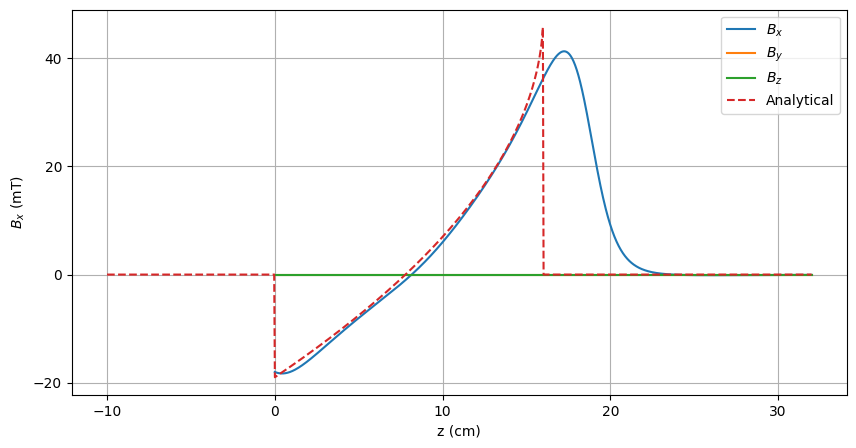

In [242]:
z = np.linspace(0,2*L,1000)
b_y = []
b_z = []
b_x = []
for i in z:
    b_x.append(zeeman_prof.getB([0,0,i*10])[0])
    b_y.append(zeeman_prof.getB([0,0,i*10])[1])
    b_z.append(zeeman_prof.getB([0,0,i*10])[2])
    

fig,ax = plt.subplots(1,1,figsize=(10,5))    
plt.plot(z,np.array(b_x)*1e3)
plt.plot(z,np.array(b_y)*1e3)
plt.plot(z,np.array(b_z)*1e3)
plt.yticks([-20,0,20,40])

plt.xlabel('z (cm)')
plt.plot(x*x0,np.array(magg)*1e3, '--')

plt.ylabel('$B$ (mT)')
plt.legend(['$B_x$','$B_y$','$B_z$','Analytical'])  
plt.ylabel('$B_x$ (mT)')
plt.grid()

# Setting YB 173 system

In [247]:
# Define the atomic Hamiltonian:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
0, 5/2, 0,  	-0.2592,
    Ahfs = 0, Bhfs=0, Chfs=0,
    muB=1)# ground state 1s0
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
1, 5/2, 1.035,	-0.2592,
    Ahfs=59.52*1e6,Bhfs = 601.87*1e6 , Chfs= 0,
    muB=1) #excited state 1p1

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, 5/2)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))
hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
hamiltonian_D2.add_H_0_block('g', H_g_D2)
hamiltonian_D2.add_H_0_block('e', H_e_D2)
hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)



#ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)
det_1 = np.linspace(0,-20,100)
vc = x0/(t0*100)
# Define the atomic Hamiltonian:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
0, 5/2, 0,  	-0.2592,
    Ahfs = 0, Bhfs=0, Chfs=0,
    muB=1)# ground state 1s0
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
1, 5/2, 1.035,	-0.2592,
    Ahfs=59.52*1e6,Bhfs = 601.87*1e6 , Chfs= 0,
    muB=1) #excited state 1p1

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, 5/2)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))
hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
hamiltonian_D2.add_H_0_block('g', H_g_D2)
hamiltonian_D2.add_H_0_block('e', H_e_D2)
hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)



#ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)

bf = lambda R: cts.value('Bohr magneton')*b_tot.getB(R*10*x0)*t0/cts.hbar
l = 16/x0
#bf = lambda R: mag(R,b_0,alpha,l)
laserBeams = pylcp.laserBeams([
    {'kvec':np.array([0, 0, -1]), 's': 100,'pol_coord':'spherical', 'pol': 1, 'delta': (E_e_D2[2]-E_g_D2[0]) + -17*gamma},],
    beam_type=pylcp.infinitePlaneWaveBeam) 
linGrad = pylcp.magField(lambda R: bf(R))

In [248]:

rateeq = pylcp.rateeq(laserBeams, linGrad, hamiltonian_D2, include_mag_forces=True)

In [249]:
force_profiles

{'1': array([[-1.76507095e-02, -1.71500833e-02, -1.78414962e-02, ...,
         -3.71082928e-01, -3.71130982e-01, -3.71172686e-01],
        [-1.76107982e-02, -1.71126001e-02, -1.77992534e-02, ...,
         -2.04746562e-01, -2.04687235e-01, -2.04635796e-01],
        [-1.72009803e-02, -1.67316891e-02, -1.73766864e-02, ...,
         -8.78629719e-02, -8.78440829e-02, -8.78277144e-02],
        ...,
        [-5.31459865e-05, -5.27186628e-05, -5.21758172e-05, ...,
         -4.91092944e-05, -4.91092760e-05, -4.91092862e-05],
        [-5.20001076e-05, -5.15735213e-05, -5.10409062e-05, ...,
         -4.81123080e-05, -4.81122901e-05, -4.81123003e-05],
        [-5.08916081e-05, -5.04658899e-05, -4.99431074e-05, ...,
         -4.71453754e-05, -4.71453579e-05, -4.71453681e-05]]),
 '2': array([[-1.76342252e-02, -1.71352531e-02, -1.78253913e-02, ...,
         -2.54218620e-01, -2.54159200e-01, -2.54107704e-01],
        [-1.76498959e-02, -1.71491689e-02, -1.78403799e-02, ...,
         -3.52787854e-01, -3

# calculating and ploting force proifle

In [282]:
det = np.linspace(-30,0,100)

force_profiles = {}
det = np.linspace(0,30,50)
j  = 0 
b = 0

laserBeams = pylcp.laserBeams([
{'kvec':np.array([0, 0, -1]), 's': 5,'pol_coord':'spherical', 'pol': np.array([1,0,1]), 'delta': (E_e_D2[2]-E_g_D2[0]) - det[24]*gamma},],
beam_type=pylcp.infinitePlaneWaveBeam) 
rateeq = pylcp.rateeq(laserBeams, linGrad, hamiltonian_D2, include_mag_forces=True)
x = np.arange(0, 2*L, 0.5)/(x0)
v = np.arange(0, 1500,10)/vc


X, V = np.meshgrid(x, v)

Rvec = np.array([np.zeros(X.shape), np.zeros(X.shape), X])
Vvec = np.array([np.zeros(V.shape), np.zeros(V.shape), V])

rateeq.generate_force_profile(Rvec, Vvec, name='Fz', progress_bar=True)

force_profiles[f'{j}'] = rateeq.profile['Fz'].F[2]

b = b +1
print(b)

c:\Users\benfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pylcp\rateeq.py:264: ComplexWarning:

Casting complex values to real discards the imaginary part



Completed in 1:17.                                                  
1


C:\Users\benfo\AppData\Local\Temp\ipykernel_12692\2980780120.py:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Text(0.5, 1.0, 'Contour plot of position vs velocity and force')

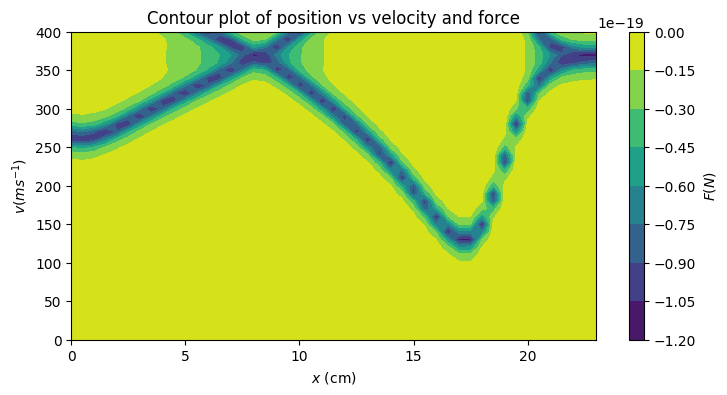

In [251]:

fig,ax = plt.subplots(1, 1, figsize=(8, 4)) 
cmap_reversed = plt.cm.get_cmap('viridis_r')
Fc = gammalab*cts.hbar*klab*100
im1 = ax.contourf(np.array(x)*x0, np.array(v)*vc, rateeq.profile['Fz'].F[2]*Fc)
fig.subplots_adjust(left=0.08, wspace=0.2)
plt.xlim([0, 23])
plt.ylim([0,400])
cb1 = plt.colorbar(im1)
cb1.set_label('$F(N)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v (ms^{-1})$')
plt.title('Contour plot of position vs velocity and force')

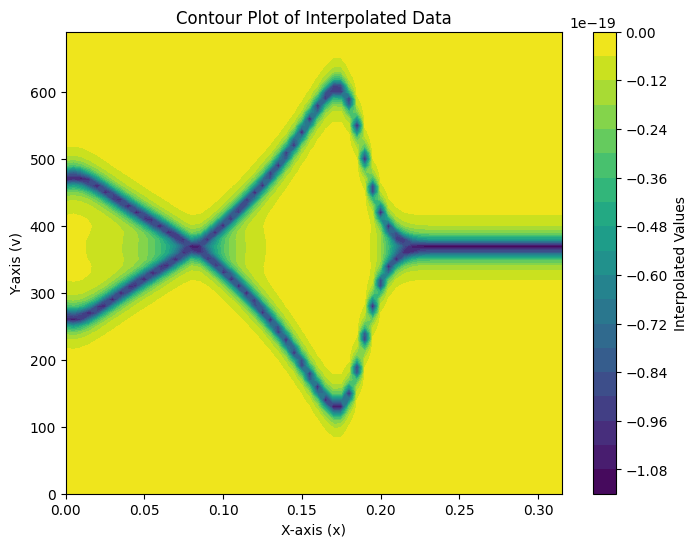

In [253]:
# check of ithe inportlation of force profile
  # Example 2D grid of values
L = 16
# Create the interpolator
f_interp = RegularGridInterpolator((np.array(v)*vc,np.array(x)*x0/100),rateeq.profile['Fz'].F[2] * Fc,method='linear')


# Generate a fine grid for plotting
x_fine = np.arange(0, 2*L, 0.5)/100# Fine grid for x-axis
v_fine =  np.arange(0,700 ,10) # Fine grid for v-axis
V,X  = np.meshgrid(v_fine, x_fine)  # Create a 2D grid

# Interpolate on the fine grid
points = np.array([V.flatten(), X.flatten()]).T  # Flatten grid into (n, 2) points
Z = f_interp(points).reshape(X.shape)  # Interpolated values reshaped to grid

# Create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, V, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label="Interpolated Values")
plt.xlabel("X-axis (x)")
plt.ylabel("Y-axis (v)")
plt.title("Contour Plot of Interpolated Data")
plt.show()

# Modeling velocity distribution of Yb-173 atoms out of 450 degree oven

In [252]:
def find_nearest_value(lst, target):
    nearest = min(lst, key=lambda x: abs(x - target))
    return nearest

In [254]:
# Constants
k_B = 1.38065e-23  # Boltzmann constant in J/K
mass_amu = 173  # Atomic mass of Yb-173
mass_kg = mass_amu * 1.66054e-27  # Convert to kilograms
temperature = 405 + 273.15  # Convert Celsius to Kelvin

# Velocity Probability Function
def p(m, T, v):
    return (m / (k_B * T))**2 * np.exp(-m * v**2 / (2 * k_B * T)) * (v**3) / 2

In [255]:
class MaxwellBoltzmann(rv_continuous):
    def _pdf(self, v):
        return p(mass_kg, temperature, v)

# Define the custom distribution
maxwell_boltzmann = MaxwellBoltzmann(a=0, name="Maxwell-Boltzmann")

10000


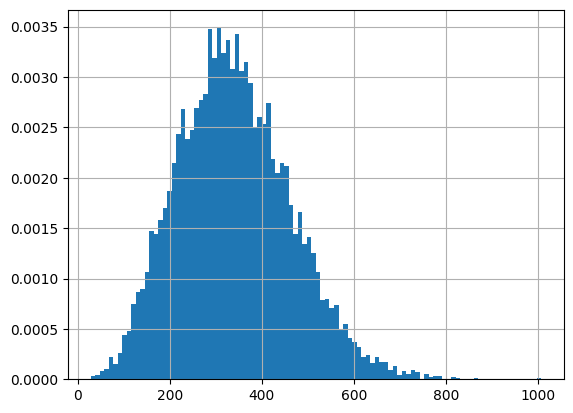

In [279]:
size = 10000# Number of samples
velocities = maxwell_boltzmann.rvs(size=size)

# Display the sampled velocities
print(len(velocities))
plt.hist(velocities, bins=100, density=True)
plt.grid()

In [281]:
max(velocities)

1006.9830505258022

# calculating trajectories 

In [257]:
f = rateeq.profile['Fz'].F[2]*Fc
f_interp = RegularGridInterpolator((np.array(v)*vc,np.array(x)),f,method = 'linear')

def simulate_trajectory(v_0, t_span,f_interp, mass_lab):
    x_t, v_t, t = [], [], []
    s, di = 0, 0  # Initial conditions

    for q in range(len(t_span)):
        dt = t_span[q] - di

        if s > 0.23 or v_0 < 0:  # Break condition
            break

        # Interpolate the force profile
        
        a = f_interp((v_0, s)) / mass_lab

        # Update position and velocity

        s = (1/2)*a*(dt**2) + v_0*dt + s
        
        v_0 = v_0 + a*dt

        # Append values
        x_t.append(s)
        v_t.append(v_0)
        t.append(t_span[q])
        di = t_span[q]
        #print(v_t)
       

    return v_t, x_t, t

In [258]:
velocities[0]

290.71607074555885

In [285]:
v_z_n = []
z_t_n = []
capture_effeciecency = []
v_z_n = []
t_n_all = []
t_max = 0.05
t_span = np.linspace(0, t_max, 10000)

#for key in force_profiles:
f_interp = RegularGridInterpolator((np.array(v)*vc,np.array(x)*x0/100),rateeq.profile['Fz'].F[2]*Fc,method='linear')
v_z = []
z_t = []
t_n = []
for i in range(len(velocities)):
        v_t,x_t,t = simulate_trajectory(velocities[i], t_span, f_interp,mass_lab)
        v_z.append(v_t)
        z_t.append(x_t)
c = 0
for i in v_z:
        if i[-1] < 50:
                c = c+1 
print(c)
capture_effeciecency.append(c)
#plt.plot(det,capture_effeciecency)

3658


In [301]:
c/10000*100

36.58

In [286]:
final_velocity = []
initial_velocity = []
for i in v_z:
    final_velocity.append(i[-1])
    initial_velocity.append(i[0])

In [275]:
c = 0
for i in v_z:
        if i[-1] < 144:
                c = c+1 
print(c)

41


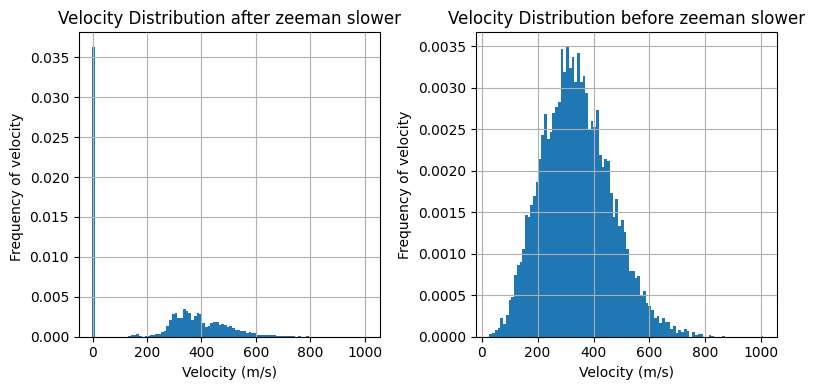

In [314]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].hist(final_velocity, bins=100, density=True)
ax[1].hist(initial_velocity, bins=100, density=True)

ax[0].grid()
ax[1].grid()
ax[0].set_title('Velocity Distribution after zeeman slower')
ax[1].set_title('Velocity Distribution before zeeman slower')
ax[0].set_ylabel('Frequency of velocity ')
ax[1].set_xlabel('Velocity (m/s)' )
ax[0].set_xlabel('Velocity (m/s)')
ax[1].set_ylabel('Frequency of velocity')
plt.tight_layout()


In [309]:
p = 0
for i in velocities:
    if i < 50:
        p = c+1
print(p*100/10000)

36.59


Text(0, 0.5, 'Final Velocity(m/s)')

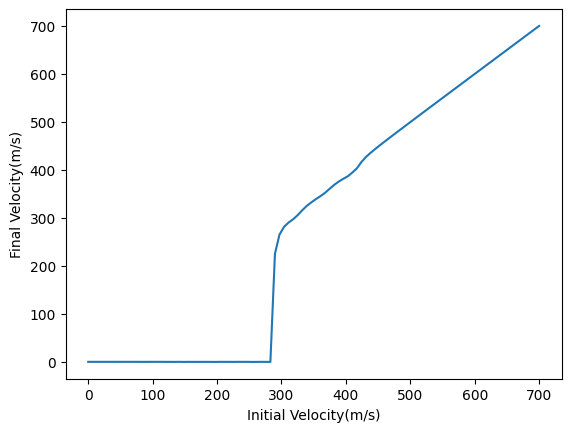

In [272]:
plt.plot(initial_velocity,final_velocity)
plt.xlabel('Initial Velocity(m/s)')
plt.ylabel('Final Velocity(m/s)')

Text(0, 0.5, 'Capture Efficiency')

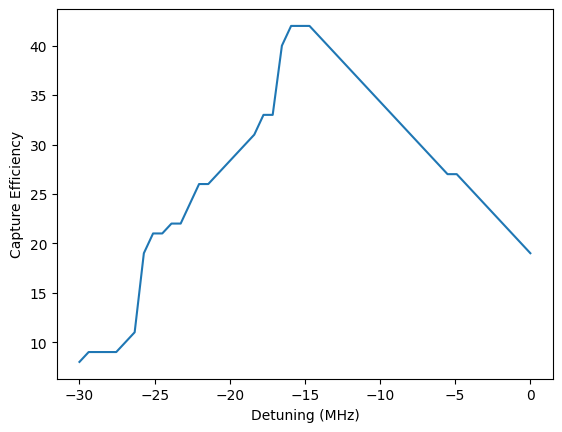

In [ ]:
plt.plot(-det*,capture_effeciecency)
plt.xlabel('Detuning (MHz)')
plt.ylabel('Capture Efficiency')

In [ ]:
c = 0
for i in velocities:
    if i  <144:
        c = c+1


4.15

0.38

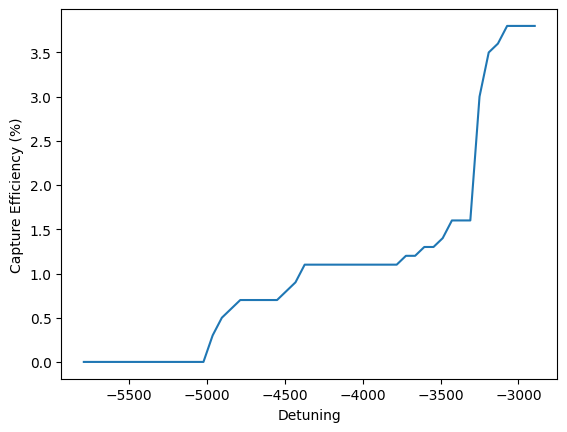

In [ ]:
plt.plot(det*gammalab/1e6,np.array(capture_effeciecency))
plt.xlabel('Detuning')
plt.ylabel('Capture Efficiency (%)')
max(capture_effeciecency)/10

In [ ]:
v_n()

NameError: name 'v_n' is not defined

In [ ]:
c = 0
for i in velocities:
    if i < 50:
        c = c+1
print(c/10000)

0.0011


In [ ]:
plt.hist()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
